### 오토인코더(autoencoder)
- 노이즈 제거, 노이즈를 제거한 이미지 복원



In [1]:
import torch

EPOCH = 5
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')
DEVICE

device(type='cuda')

In [2]:
# from keras.datasets import mnist
from torchvision import transforms, datasets
import numpy as np

# (x_tr, _), (x_ts, _) = mnist.load_data()
trainset = datasets.FashionMNIST(
    root = 'c:/data/',
    train=True,
    download=True,
    transform = transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 2
)

In [3]:
from torch import nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # 784 >> 3차원 압축
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12,3),
        )

        # 3 >> 784 복원
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [4]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = 0.005)
criterion = nn.MSELoss()

In [10]:
def add_noise(img):
    noise = torch.randn(img.size()) * 0.2
    noisy_img = img + noise
    return noisy_img

def train(autoencoder, train_loader):
    autoencoder.train()
    avg_loss = 0
    for step, (x, label) in enumerate(train_loader):
        x = add_noise(x)     # 노이즈 추가
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)
        label = label.to(DEVICE)
        encoded, decoded = autoencoder(x)
        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss.item()
    return avg_loss / len(train_loader)

In [11]:
for epoch in range(1, EPOCH+1):
    loss = train(autoencoder, train_loader)
    print('[Epoch {}] loss: {}'.format(epoch, loss))

[Epoch 1] loss: 0.07802979992047301
[Epoch 2] loss: 0.0681621611181861
[Epoch 3] loss: 0.06538303020094503
[Epoch 4] loss: 0.06441819811585361
[Epoch 5] loss: 0.06375169947044428


In [13]:
testset = datasets.FashionMNIST(
    root = 'c:/data/',
    train=False,
    download=True,
    transform = transforms.ToTensor()
)

idx=99 #샘플번호
sample_data = testset.data[idx].view(-1, 28*28)
sample_data = sample_data.type(torch.FloatTensor)/255.

original_x = sample_data[0]
noisy_x = add_noise(original_x).to(DEVICE) # 노이즈 추가
_, recovered_x = autoencoder(noisy_x)

In [14]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

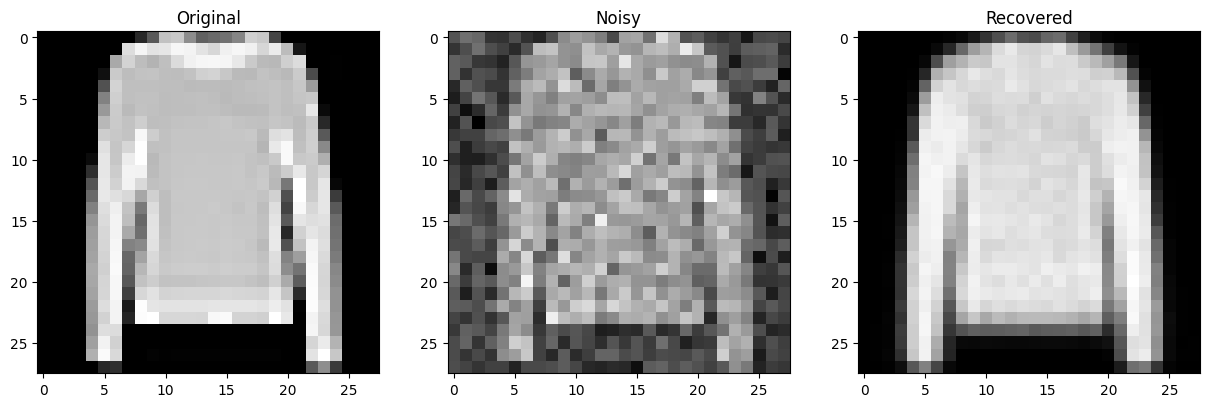

In [15]:
import matplotlib.pyplot as plt

f, a = plt.subplots(1,3, figsize=(15,15))

original_img = np.reshape(original_x.to('cpu').data.numpy(), (28, 28))
noisy_img = np.reshape(noisy_x.to('cpu').data.numpy(), (28, 28))
recovered_img = np.reshape(recovered_x.to('cpu').data.numpy(), (28, 28))

a[0].set_title("Original")
a[0].imshow(original_img, cmap='gray')

a[1].set_title("Noisy")
a[1].imshow(noisy_img, cmap='gray')

a[2].set_title("Recovered")
a[2].imshow(recovered_img, cmap='gray')

plt.show()
